# MNIST — Demo Notebook

### Overview
This notebook provides demonstration of the MNIST classification pipeline.
It illustrates how the models are trained, evaluated, and tested under various edge conditions.

### What’s included
-  **Quick runs** for `Random Forest`, `FNN`, and `CNN` (2 epochs by default for speed)
-  **Evaluation metrics:** accuracy, classification report, and confusion matrix
-  **Prediction examples:** correct and misclassified digits
-  **Edge-case tests:** input shape errors, dtype mismatches, NaN handling, out-of-range labels, and class imbalance

>  **Note:**
> This notebook is meant for demonstration and documentation.
> Keep training short here — full training sessions should be executed via `main.py`.


In [2]:
import sys, os, random
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def seed_everything(seed: int = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print({'python': sys.version.split()[0], 'torch': torch.__version__, 'cuda_available': torch.cuda.is_available(), 'device': str(DEVICE)})

{'python': '3.13.5', 'torch': '2.8.0+cpu', 'cuda_available': False, 'device': 'cpu'}


## 2. Import your module

Import the local **`mnist`** package so this demo runs on your own implementation.
Since the notebook is inside `notebooks/`, i have added the project root to `sys.path`
to make the package importable.

In [3]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("Available submodules:", [n for n in dir(models) if not n.startswith("_")])
print("Successfully imported MNIST package")


Available submodules: ['MnistClassifier', 'data', 'facade', 'interface', 'models']
Successfully imported MNIST package


## 3. Data Load

I have used the custom function `load_mnist_numpy()` from the `mnist.data` module.
It returns the MNIST dataset already split into **training**, **validation**, and **test** sets —
each as NumPy arrays.

The function loads images as `(N, 28, 28)` arrays and labels as `(N,)`,
so they’re ready for both classical models (like Random Forest) and neural networks.

Below data is loading and printing the result shapes to verify everything is correct.


In [4]:

from Task1.mnist import data

X_train, y_train, X_val, y_val, X_test, y_test = data.load_mnist_numpy()
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


100.0%
100.0%
100.0%
100.0%


((54000, 28, 28), (6000, 28, 28), (10000, 28, 28), (54000,), (6000,), (10000,))

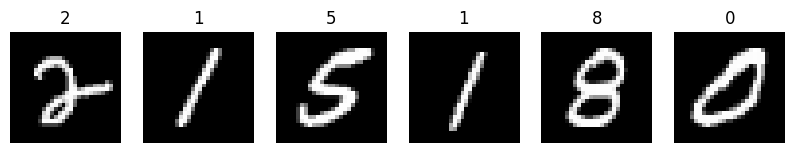

In [5]:
fig, axes = plt.subplots(1, 6, figsize=(10,2))
for i in range(6):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(int(y_train[i]))
    axes[i].axis('off')
plt.show()

## 4. Baseline — Random Forest (flattened pixels)

Let's start with a **Random Forest** as a simple non-neural baseline.
This model operates on flattened pixel vectors — each image of shape `(28, 28)`
is reshaped into a 1D vector of length `784`.

Using the unified interface `MnistClassifier("rf")`,
i have trained the model, maked predictions on the test set, and evaluated its accuracy.


In [6]:
rf = models.MnistClassifier('rf')
rf.train(X_train, y_train, X_val, y_val)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print('RF test accuracy:', acc_rf)
print(classification_report(y_test, y_pred_rf))

RF test accuracy: 0.9691
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## 5. FNN — short demo (2 epochs)

The **Feed-Forward Neural Network (FNN)** is a simple fully connected model
where data flows only in one direction — from input to output.
It’s implemented as a small **multi-layer perceptron (MLP)** with linear layers, activations, and a softmax output.



In [7]:
fnn = models.MnistClassifier('nn', epochs=2, batch_size=128, lr=1e-3, print_val=True)

fnn.train(X_train, y_train, X_val, y_val)
y_pred_fnn = fnn.predict(X_test)

acc_fnn = accuracy_score(y_test, y_pred_fnn)
print('FNN test accuracy:', acc_fnn)
print(classification_report(y_test, y_pred_fnn))


[MLP] epoch 01 | train_loss=0.3888 | val_acc=0.9432
[MLP] epoch 02 | train_loss=0.1557 | val_acc=0.9602
FNN test accuracy: 0.9623
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.97      0.94      0.96      1010
           4       0.97      0.95      0.96       982
           5       0.97      0.95      0.96       892
           6       0.95      0.98      0.96       958
           7       0.98      0.96      0.97      1028
           8       0.91      0.97      0.94       974
           9       0.97      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



## 6. CNN — short demo (2 epochs)

The **Convolutional Neural Network (CNN)** is designed to capture local spatial patterns
by applying convolutional filters over the image.
Unlike FNNs, it preserves the 2D structure of the input, making it much better suited for image data.



In [8]:
cnn = models.MnistClassifier('cnn', epochs=2, batch_size=128, lr=1e-3, print_val=True)
cnn.train(X_train, y_train, X_val, y_val)
y_pred_cnn = cnn.predict(X_test)
acc_cnn = accuracy_score(y_test, y_pred_cnn)
print('CNN test accuracy:', acc_cnn)
print(classification_report(y_test, y_pred_cnn))

[CNN] epoch 01 | train_loss=0.2609 | val_acc=0.9715
[CNN] epoch 02 | train_loss=0.0629 | val_acc=0.9817
CNN test accuracy: 0.9841
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.97      1.00      0.98       982
           5       0.98      0.99      0.98       892
           6       1.00      0.97      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.99      0.96      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## 7. Confusion Matrix (CNN)

To better visualize model performance, i have ploted the **confusion matrix** for the CNN predictions.
It shows how often each digit is correctly classified versus confused with another.

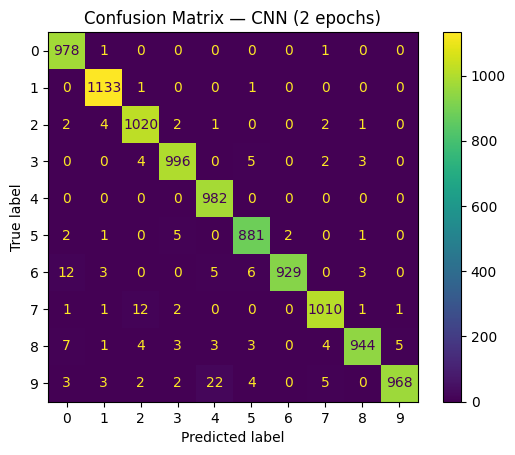

In [9]:
cm = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='d')
plt.title('Confusion Matrix — CNN (2 epochs)')
plt.show()

## 8. Inference examples
Let's see few predictions (including mistakes if any).

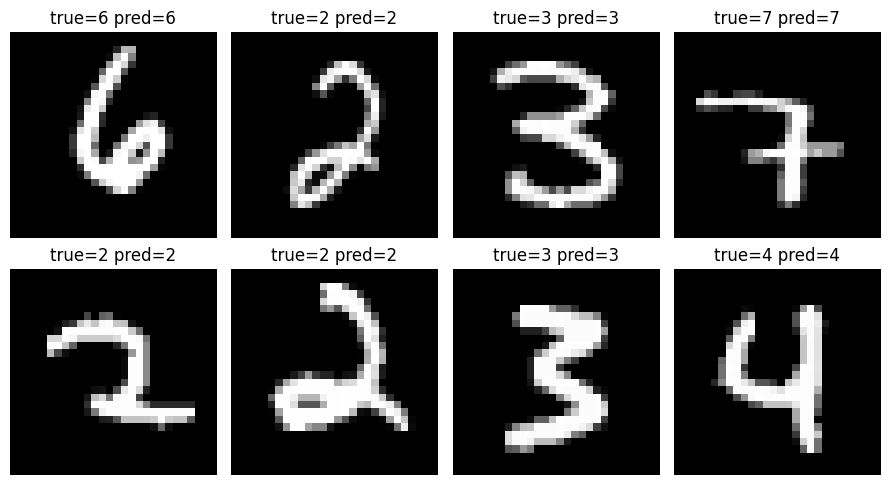

In [10]:
idx = np.random.choice(len(X_test), size=8, replace=False)
imgs = X_test[idx]
y_true = y_test[idx]
preds = y_pred_cnn[idx]

fig, axes = plt.subplots(2, 4, figsize=(9,5))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(imgs[i], cmap='gray')
    ax.set_title(f"true={int(y_true[i])} pred={int(preds[i])}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## 9. Edge cases
Demonstrating how the current implementation behaves under common pitfalls.

Covered:
- **Shape handling**: high-level API adds channel dim automatically for NN/CNN
- **Dtype coercion**: float64 → float32
- **NaNs in inputs**: forward works but produces NaNs; training quality degrades
- **Out-of-range labels**: loss throws a clear error
- **Imbalanced mini-subset**: accuracy is misleading → look at macro-F1

In [12]:
from __future__ import annotations

import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score, f1_score

from Task1.mnist.models import SimpleCNN
from Task1.mnist.models import add_channel_dim

print("— Edge cases —")

X_small = X_test[:4]
preds_ok = cnn.predict(X_small)
print("[Shape handling] high-level predict OK →", preds_ok)

raw = SimpleCNN().to(DEVICE)
try:
    _ = raw(torch.as_tensor(X_small, device=DEVICE))
    print("[Shape handling] raw forward UNEXPECTEDLY worked on wrong shape")
except Exception as e:
    print("[Shape handling] raw forward error (expected):", type(e).__name__, str(e)[:140])

X64 = X_small.astype(np.float64)
preds_64 = cnn.predict(X64)
print("[Dtype coercion] predict on float64 inputs OK →", preds_64)

Xnan = X_small.copy()
Xnan[0, 0, 0] = np.nan
try:
    if np.isnan(Xnan).any():
        raise ValueError("NaNs detected in inputs")
    preds_nan = cnn.predict(Xnan)
    print("[NaNs] predict succeeded (lenient pipeline) →", preds_nan)
except Exception as e:
    print("[NaNs] error (expected for strict pipelines):", type(e).__name__, str(e)[:140])

xb = torch.as_tensor(add_channel_dim(X_small), dtype=torch.float32, device=DEVICE)
logits = SimpleCNN().to(DEVICE)(xb)
bad_y = torch.tensor([0, 1, 2, 99], device=DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()
try:
    _ = loss_fn(logits, bad_y)
    print("[Out-of-range labels] UNEXPECTEDLY no error")
except Exception as e:
    print("[Out-of-range labels] error (expected):", type(e).__name__, str(e)[:140])

mask_major = (y_test == 1)
mask_minor = (y_test == 7)

X_major, y_major = X_test[mask_major][:180], y_test[mask_major][:180]
X_minor, y_minor = X_test[mask_minor][:20],  y_test[mask_minor][:20]

X_imb = np.concatenate([X_major, X_minor], axis=0)
y_imb = np.concatenate([y_major, y_minor], axis=0)

preds_imb = cnn.predict(X_imb)
acc_imb = accuracy_score(y_imb, preds_imb)
macro_f1_imb = f1_score(y_imb, preds_imb, average="macro")

print(f"[Imbalanced subset] size={len(y_imb)} (major=1 x{len(y_major)}, minor=7 x{len(y_minor)})"
      f" | accuracy={acc_imb:.3f} | macro-F1={macro_f1_imb:.3f}")
print(classification_report(y_imb, preds_imb, digits=3))


— Edge cases —
[Shape handling] high-level predict OK → [7 2 1 0]
[Shape handling] raw forward error (expected): RuntimeError Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 4, 28, 28] to have 1 channels, but got 4 channels instead
[Dtype coercion] predict on float64 inputs OK → [7 2 1 0]
[NaNs] error (expected for strict pipelines): ValueError NaNs detected in inputs
[Out-of-range labels] error (expected): IndexError Target 99 is out of bounds.
[Imbalanced subset] size=200 (major=1 x180, minor=7 x20) | accuracy=1.000 | macro-F1=1.000
              precision    recall  f1-score   support

           1      1.000     1.000     1.000       180
           7      1.000     1.000     1.000        20

    accuracy                          1.000       200
   macro avg      1.000     1.000     1.000       200
weighted avg      1.000     1.000     1.000       200



## 10. FAQ / How to run locally
- Install deps: `pip install torch torchvision scikit-learn matplotlib`
- Start Jupyter: `jupyter lab` (or Notebook)
- This demo uses **short training** (2 epochs) to run fast; full runs belong in scripts.
- Data: `torchvision.datasets.MNIST` auto-downloads on first run (internet needed once).